In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from tqdm import tqdm
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from datetime import datetime
from torchvision import models
from transformers import CLIPProcessor, CLIPModel
import os
import csv
from peft import LoraConfig, get_peft_model
import json

KeyboardInterrupt: 

In [ ]:
root = "/content/drive/MyDrive/MASTER_THESIS/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
ARTWORKS = pd.read_csv(root + "artpieces.csv")
ARTWORKS

,recordID,workID,creatorID,language,title,objectWorkType,termClassification,materials,signatureFullDescription,creationFullDescription,...,physicalAppearanceDescription,imageType,imageColor,imageLowResFilename,imageHighResFilename,imageCopyright,formalDescriptionTermStylesPeriods,height,width,ratio
0,64,8181,Auth:509:309,fre,La Crucifixion,détrempe,peinture (Dept. Art Ancien),toile|tempera,NaN,1460.0,...,Tempera sur toile,digitale JPG,photo couleurs,/art-foto/old/internet/Bouts-8181dig-L.jpg,/art-foto/old/intranet/Bouts-8181dig-H.jpg,NaN,Primitifs flamands,181.5,153.5,0.845730
1,77,11120,Auth:509:255,fre,Jeune fille assise,dessin,oeuvre sur papier (Dept. Art Moderne),papier|carton|colle|crayon|pastel,Signature dans la bas à droite : Gust. De Smet,1929.0,...,Crayon et pastel sur papier collé sur carton,digitale JPG,photo couleurs,/art-foto/mod/Internet/deSmet-11120dig-L.jpg,/art-foto/mod/Intranet/deSmet-11120dig-H.jpg,NaN,NaN,NaN,NaN,NaN
2,78,3980,Auth:509:70,fre,Portrait de Mademoiselle Van der Hecht,tableau (toile),peinture (Dept. Art Moderne),toile|peinture à l'huile,Signature et date dans le haut à droite: FERNA...,1883.0,...,Huile sur toile,digitale JPG,photo couleurs,/art-foto/mod/Internet/Khnopff-3980dig-L.jpg,/art-foto/mod/Intranet/Khnopff-3980dig-H.jpg,NaN,Peinture de portraits,37.0,29.0,0.783784
3,79,6366,Auth:509:70,fre,En écoutant du Schumann,tableau (toile),peinture (Dept. Art Moderne),toile|peinture à l'huile,Signature et date dans le haut vers la gauche ...,1883.0,...,Huile sur toile,digitale JPG,photo couleurs,/art-foto/mod/Internet/Khnopff-6366dig-L.jpg,/art-foto/mod/Intranet/Khnopff-6366dig-H.jpg,NaN,NaN,101.5,116.5,1.147783
4,80,6768,Auth:509:70,fre,Des caresses,tableau (toile),peinture (Dept. Art Moderne),toile|peinture à l'huile,Signature et date en bas à droite : FERNAND KH...,1896.0,...,Huile sur toile,digitale JPG,photo couleurs,/art-foto/mod/Internet/Khnopff-6768dig-L.jpg,/art-foto/mod/Intranet/Khnopff-6768dig-H.jpg,NaN,Symbolisme,50.5,151.0,2.990099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5296,13322,11972,Auth:509:82,fre,Page de carnet de croquis,dessin,oeuvre sur papier (Dept. Art Moderne),papier|fusain|crayon,NaN,NaN,...,Crayon et fusain sur papier,digitale JPG,photo couleurs,/art-foto/mod/internet/Meunier-11972r-L.jpg,/art-foto/mod/intranet/Meunier-11972r-H.jpg,NaN,NaN,NaN,NaN,NaN
5297,13323,11973,Auth:509:4126,fre,Lot de 12 oeuvres documentaires (11 dessins + ...,dessin,oeuvre sur papier (Dept. Art Moderne),papier,NaN,NaN,...,Techniques diverses sur feuilles de carnet de ...,digitale JPG,photo couleurs,/art-foto/mod/internet/Meunier-11973_1-L.jpg,/art-foto/mod/intranet/Meunier-11973_1-H.jpg,NaN,NaN,NaN,NaN,NaN
5298,13377,3399,Auth:509:1442,fre,Portrait de femme. Mademoiselle Collyns,pastel,oeuvre sur papier (Dept. Art Moderne),papier|pastel|carton,Signature et date vers le bas à droite : Eugèn...,1897.0,...,Pastel sur papier collé sur carton,digitale JPG,photo couleurs,/art-foto/mod/internet/Devaux-3399-L.jpg,/art-foto/mod/intranet/Devaux-3399-H.jpg,NaN,NaN,NaN,NaN,NaN
5299,13379,4787,Auth:509:85,fre,Mère et enfant,dessin,oeuvre sur papier (Dept. Art Moderne),papier|fusain|carton,"Non signé, non daté",NaN,...,"Fusain sur papier, collé sur carton",digitale JPG,photo couleurs,/art-foto/mod/internet/Minne-4787-L.jpg,/art-foto/mod/intranet/Minne-4787-H.jpg,NaN,NaN,NaN,NaN,NaN


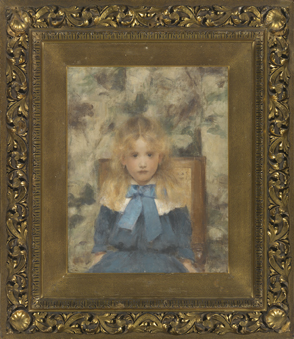

In [ ]:
def fixPath(path):
    return path.replace(".././", "../")

def get_image_path_from_recordID(dataset, recordID):
    """
    Given a recordID, return the local path for its image.
    """
    # Locate row in the downloaded DataFrame
    paths = dataset[
        dataset["recordID"] == recordID
    ]["imageLowResFilename"].values

    if len(paths) == 0:
        return None

    path = paths[0]
    # Merge: IMAGES_FOLDER + path[1:]
    path = fixPath(root + "images/" + path[1:])

    path = path.replace("internet", "Internet")
    path = path.replace("Mod", "mod")
    path = path.replace("MOD", "mod")
    path = path.replace("Old", "old")
    path = path.replace("Stefaan", "stefaan")
    path = path.replace("Art-Foto", "art-foto")
    path = path.replace("\\", "/")

    return path

# Test it
recordID = 2256
print(recordID)
print(get_image_path_from_recordID(ARTWORKS, recordID))
# Open the image
from PIL import Image
image = Image.open(get_image_path_from_recordID(ARTWORKS, recordID))
# Plot using matplotlib
from matplotlib import pyplot as plt
plt.imshow(image)
plt.show()

In [ ]:
best_workers = 8
BATCH_SIZE = 32
criterion = nn.CrossEntropyLoss()

In [ ]:
model_name = "march_finetuned"
model_weights_path = root + "/models/2025-03-29 16 59 53_allFocus_5.pt"

model_name = "openai/clip-vit-large-patch14"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name).to(device)
model.load_state_dict(torch.load(model_weights_path, weights_only=True))

print("Model loaded")

Model loaded


In [ ]:
VALIDATION_SET_FR = root + "merged_data_validation_set.csv"
VALIDATION_SET_EN = root + "merged_data_validation_set_en.csv"
VALIDATION_SET_NL = root + "merged_data_validation_set_nl.csv"

print(VALIDATION_SET_FR.head(1)["caption"].tolist())
print(VALIDATION_SET_EN.head(1)["caption"].tolist())
print(VALIDATION_SET_NL.head(1)["caption"].tolist())

['Une fête, un repas, une foule en intérieur, des enfants qui jouent, richesse, Lumineux']
['A party, a meal, a crowd inside, children playing, rich, bright']
['Een feestje, een maaltijd, een menigte binnen, kinderen spelen, rijk, helder']


In [ ]:
class ManualDataset(Dataset):
    def __init__(self, DATASET, get_image_path_from_recordID):
        self.DATASET = DATASET
        self.get_image_path_from_recordID = get_image_path_from_recordID

    def __len__(self):
        return len(self.DATASET)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.DATASET.iloc[idx]

        # recordID	category	focus	caption	length_tokenization
        record_id = row['recordID']
        row_type = row['focus']
        caption = row['caption']
        path = self.get_image_path_from_recordID(ARTWORKS, record_id)

        image = Image.open(path)

        return image, record_id, row_type, caption
    
def customBatchBuilder(samples):
    images, record_ids, row_types, captions = zip(*samples)
    inputs = processor(text=captions, images=images, return_tensors="pt", padding=True, truncation=True)
    return inputs, row_types

LANGS = {
    "FR": VALIDATION_SET_FR,
    "EN": VALIDATION_SET_EN,
    "NL": VALIDATION_SET_NL
}
DATALOADERS = {}
DATASETS = {}
for lang in LANGS:
    DATAFRAME = LANGS[lang]
    DATALOADERS[lang] = {}
    DATASETS[lang] = {}

    # All focus
    DATASET__VALIDATION_ALL_FOCUS = ManualDataset(DATAFRAME, get_image_path_from_recordID)
    DATALOADER__VALIDATION_ALL_FOCUS = DataLoader(
        DATASET__VALIDATION_ALL_FOCUS,
        batch_size=BATCH_SIZE,
        shuffle=True,

        num_workers=best_workers,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True,

        collate_fn=customBatchBuilder
    )
    DATALOADERS[lang]["all_focus"] = DATALOADER__VALIDATION_ALL_FOCUS
    DATASETS[lang]["all_focus"] = DATASET__VALIDATION_ALL_FOCUS

    # Since we have multiple captions per image, we want to make a Dataset that allow us to measure the performance of the model on each focus
    DATASET__VALIDATION_PER_FOCUS   = {}

    for focus in ["content", "emotion", "colors", "luminosity"]:
        DATASET__VALIDATION_PER_FOCUS[focus]    = ManualDataset(DATAFRAME[DATAFRAME["focus"] == focus], get_image_path_from_recordID)

    # Make dataloaders
    for focus in ["content", "emotion", "colors", "luminosity"]:
        DATALOADER__VALIDATION_FOR_FOCUS = DataLoader(
            DATASET__VALIDATION_PER_FOCUS[focus],
            batch_size=BATCH_SIZE,

            shuffle=True,
            num_workers=best_workers,
            pin_memory=True,
            prefetch_factor=2,
            persistent_workers=True,

            collate_fn=customBatchBuilder
        )
        DATALOADERS[lang][focus] = DATALOADER__VALIDATION_FOR_FOCUS
        DATASETS[lang][focus] = DATASET__VALIDATION_PER_FOCUS[focus]

DATALOADERS, DATASETS

({'FR': {'all_focus': <torch.utils.data.dataloader.DataLoader at 0x1ee8b444d30>,
   'content': <torch.utils.data.dataloader.DataLoader at 0x1ee92797160>,
   'emotion': <torch.utils.data.dataloader.DataLoader at 0x1ee92b5c490>,
   'colors': <torch.utils.data.dataloader.DataLoader at 0x1ee92b5c580>,
   'luminosity': <torch.utils.data.dataloader.DataLoader at 0x1ee92b5c670>},
  'EN': {'all_focus': <torch.utils.data.dataloader.DataLoader at 0x1ee92b78850>,
   'content': <torch.utils.data.dataloader.DataLoader at 0x1ee92b78f10>,
   'emotion': <torch.utils.data.dataloader.DataLoader at 0x1ee92882b50>,
   'colors': <torch.utils.data.dataloader.DataLoader at 0x1ee927a2d00>,
   'luminosity': <torch.utils.data.dataloader.DataLoader at 0x1ee927a20d0>},
  'NL': {'all_focus': <torch.utils.data.dataloader.DataLoader at 0x1ee927a2fd0>,
   'content': <torch.utils.data.dataloader.DataLoader at 0x1ee92b5e460>,
   'emotion': <torch.utils.data.dataloader.DataLoader at 0x1ee92b5e7c0>,
   'colors': <torch.u

In [ ]:
def get_average_position(cosine_similarities):
    """
    What is the Average Position?
    ==> The Average Position is a metric that evaluates the effectiveness of a recommendation algorithm.
    ==> It is the average of the positions of the correct answers.
    ==> The position of a query response is the rank of the first correct answer.
    ==> The Average Position is a number between 0 and n, where 0 means that the first correct answer is always ranked first.
    """
    average_position = 0
    for i in range(len(cosine_similarities)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        rank = np.where(sorted_indices == i)[0][0] + 1
        average_position += rank
    average_position /= len(cosine_similarities)
    return average_position

def get_MRR(cosine_similarities):
    """
    What is MRR (Mean Reciprocal Rank)?
    ==> The Mean Reciprocal Rank is a metric that evaluates the effectiveness of a recommendation algorithm.
    ==> It is the average of the reciprocal ranks of the top k items.
    ==> The reciprocal rank of a query response is the multiplicative inverse of the rank of the first correct answer.
    ==> The MRR is a number between 0 and 1, where 1 means that the first correct answer is always ranked first.
    """
    mrr = 0
    for i in range(len(cosine_similarities)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        rank = np.where(sorted_indices == i)[0][0] + 1
        mrr += 1 / rank
    mrr /= len(cosine_similarities)
    return mrr

def get_recall_at_k(cosine_similarities, k):
    """
    What is Recall@k?
    ==> The Recall@k is a metric that evaluates the effectiveness of a recommendation algorithm.
    ==> It is the proportion of the top k items that are relevant.
    ==> The Recall@k is a number between 0 and 1, where 1 means that all top k items are relevant.
    """
    recall_at_k = 0
    for i in range(len(cosine_similarities)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        if i in sorted_indices[:k]:
            recall_at_k += 1
    recall_at_k /= len(cosine_similarities)
    return recall_at_k

def get_nDCG_at_k(cosine_similarities, k):
    """
    What is nDCG@k (Discounted cumulative gain)
    ==> The nDCG@k is a metric that evaluates the effectiveness of a recommendation algorithm.
    ==> It is the normalized discounted cumulative gain at the top k items.
    ==> The nDCG@k is a number between 0 and 1, where 1 means that all top k items are relevant and perfectly ranked.
    """
    nDCG_at_k = 0
    for i in range(len(cosine_similarities)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        rank = np.where(sorted_indices == i)[0][0] + 1
        nDCG_at_k += 1 / np.log2(rank + 1) if rank <= k else 0
    nDCG_at_k /= len(cosine_similarities)
    return nDCG_at_k

In [ ]:
def benchmark_on_dataloader(model, dataset, dataloader, device):
    """
    This function measures various metrics on a dataloader:
    - Loss
    - Average Position
    - MRR (Mean Reciprocal Rank)
    - Recall@1, Recall@5, Recall@10
    - nDCG@1, nDCG@5, nDCG@10
    """
    model.eval()
    loss_tot = 0
    positions = []
    recalls = {1: 0, 5: 0, 10: 0}
    ndcgs = {1: 0, 5: 0, 10: 0}

    images_embeddings = torch.tensor([]).to(device)
    texts_embeddings = torch.tensor([]).to(device)

    with torch.no_grad():
        for sample in tqdm(dataloader):

            inputs, row_types = sample

            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            pixel_values = inputs['pixel_values'].to(device)

            # Generate model outputs
            outputs = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)
            logits_per_image = outputs.logits_per_image  # Shape: [batch_size, num_images]
            logits_per_text = outputs.logits_per_text    # Shape: [batch_size, num_texts]

            # Compute the embeddings
            image_embeddings = outputs.image_embeds
            text_embeddings = outputs.text_embeds

           # Normalize
            image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)
            text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

            # Ground truth for this batch
            batch_size = logits_per_image.size(0)
            targets = torch.arange(batch_size).to(device)  # Correct index corresponds to diagonal

            # Calculate loss
            texts_loss = criterion(logits_per_text, targets)
            images_loss = criterion(logits_per_image, targets)
            loss = (images_loss + texts_loss) / 2.0
            loss_tot += loss.item() * batch_size

            # Add the embeddings to the list
            images_embeddings = torch.cat((images_embeddings, image_embeddings), 0)
            texts_embeddings = torch.cat((texts_embeddings, text_embeddings), 0)

    # Compute the loss
    loss_per_pair = loss_tot/len(dataset) # Average loss per pair

    # Compute the cosine similarity
    similarities = images_embeddings @ texts_embeddings.T
    similarities = similarities.cpu().numpy()

    # Compute the positions
    average_position = get_average_position(similarities)
    mrr = get_MRR(similarities)
    recalls[1] = get_recall_at_k(similarities, 1)
    recalls[5] = get_recall_at_k(similarities, 5)
    recalls[10] = get_recall_at_k(similarities, 10)
    ndcgs[1] = get_nDCG_at_k(similarities, 1)
    ndcgs[5] = get_nDCG_at_k(similarities, 5)
    ndcgs[10] = get_nDCG_at_k(similarities, 10)

    return [loss_per_pair, average_position, mrr, recalls[1], recalls[5], recalls[10], ndcgs[1], ndcgs[5], ndcgs[10]]

In [ ]:
def run_benchmark(results, lang):
    print(f"Running benchmark on {lang}...")
    measures_specific_focus = []
    for focus in DATALOADERS[lang]:
        if focus=="all_focus":
            continue
        print(f"Running benchmark on {focus}...")
        measures = benchmark_on_dataloader(model, DATASETS[lang][focus], DATALOADERS[lang][focus], device)
        measures_specific_focus.append(measures)
        results.loc[len(results)] = [lang, focus] + measures
      
    # AllFocus is the mean of the other focus for this lang
    measures_all_focus = np.mean(measures_specific_focus, axis=0)
    results.loc[len(results)] = [lang, "all_focus"] + measures_all_focus

    return results

In [ ]:
results = pd.DataFrame(columns=["lang", "focus", "loss", "average_position", "mrr", "recall@1", "recall@5", "recall@10", "nDCG@1", "nDCG@5", "nDCG@10"])
results
for lang in LANGS:
    results = run_benchmark(results, lang)
# Save
results.to_csv(root + f"multilingual_results_{model_name}.csv", index=False)

Running benchmark on FR...


  0%|          | 0/954 [00:00<?, ?it/s]